In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import pickle
import scipy
import scipy.integrate as integrate
import time 
from tqdm import tqdm

import sys 
sys.path.append('../../')
from model_comparison.utils import *
from model_comparison.mdns import *
from model_comparison.models import BaseModel

from delfi.distribution.mixture import MoG
%matplotlib inline

In [4]:
mpl_params = {'legend.fontsize': 18,
              'legend.frameon': False,
                      'axes.titlesize': 21,
                      'axes.labelsize': 19,
                      'xtick.labelsize': 15,
                      'ytick.labelsize': 15,
             'figure.figsize' : (18, 5)}

mpl.rcParams.update(mpl_params)

## Bayesian model comparison with simple signal detection theory example

The task is to decide whether the observed data is a signal or background by performing Bayesian model comparison between a background and a signal model. 

The models are univariate Gaussian distributions, e.g., the background model ($H_0$ hypothesis) is a univariate Gaussian centered around 0 and the signal model (alternative hypothesis) is a univariate Gaussian with a positive mean and some known or unknown variance. 

The difference between the two models is given by the prior distrubution on the mean and the values of the fixed variance. The background model has a prior on the mean that is relatively tight around zero (small prior variance) and the variance is fixed and small. The signal model has a broader prior on the mean and a larger fixed variance. The mean and the variance of the prior on the mean scales the difficulty of the problem: the further away from zero the prior mean, the simple the model selection. 

### Visulization 

In [5]:
# thetas to evaluate 
thetas = np.linspace(-10, 10, 1000)

# example background model 
example_m0 = scipy.stats.norm(0, 2)
# signal model 
example_m1 = scipy.stats.norm(4, 3)
# draw example observed data 
xo = example_m1.rvs(1)

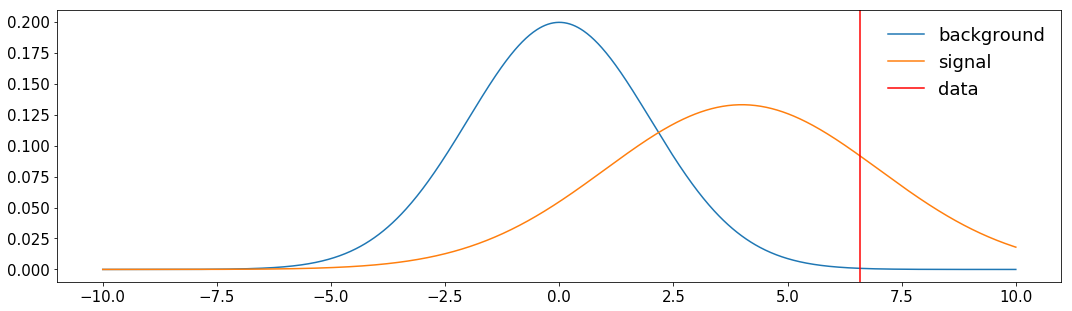

In [6]:
plt.plot(thetas, example_m0.pdf(thetas), label='background')
plt.plot(thetas, example_m1.pdf(thetas), label='signal')
plt.axvline(xo, label='data', color='r')
plt.legend();

## Set up models

In [7]:
class GaussianModel(BaseModel):
    def __init__(self, std, dim_param=1, sample_size=10, n_workers=1, seed=None):
        super().__init__(dim_param=dim_param, sample_size=sample_size, n_workers=n_workers, seed=seed)
        self.std = std
        self.posterior = None

    def gen_single(self, params):
        # in multiprocessing the parameter vector additionally contains a seed
        if self.run_parallel:
            mu, seed = params
            self.rng.seed(int(seed))
        else:
            mu = params
        return self.rng.normal(loc=mu, scale=self.std, size=self.sample_size)

In [44]:
sample_size = 1
ntrain = 1000000
ntest = 100

# background model prior 
prior_m0 = scipy.stats.norm(0, 1)
# signal model prior 
prior_m1 = scipy.stats.norm(1, 2)

# models 
m0 = GaussianModel(std=1, sample_size=sample_size)
m1 = GaussianModel(std=2, sample_size=sample_size)

## Generate parameters from the priors 

In [45]:
n = ntrain + ntest
params_m0 = prior_m0.rvs(size=int(n / 2))
params_m1 = prior_m1.rvs(size=int(n / 2))

## Generate data from models and calculate summary stats, prepare test data 

In [46]:
data_m0 = m0.gen(params_m0)
data_m1 = m1.gen(params_m1)

In [47]:
# shuffle and set up model index target vector 
x_all = np.vstack((data_m0, data_m1))

# define model indices
m_all = np.hstack((np.zeros(data_m0.shape[0]), np.ones(data_m1.shape[0]))).squeeze().astype(int)

# get shuffled indices 
shuffle_indices = np.arange(n)
np.random.shuffle(shuffle_indices)

# shuffle the data 
x_all = x_all[shuffle_indices, ]
m_all = m_all[shuffle_indices].tolist()

x, xtest = x_all[:ntrain, :], x_all[ntrain:, :]
m, mtest = m_all[:ntrain], m_all[ntrain:]

# calculate summary stats
sx = x
sx_test = xtest
# use training norm to normalize test data 
sx_zt, training_norm = normalize(sx)
sx_test_zt, training_norm = normalize(sx_test, training_norm)

## Set up the NN and train it 

training: 100%|██████████| 10/10 [00:56<00:00,  5.35s/it]


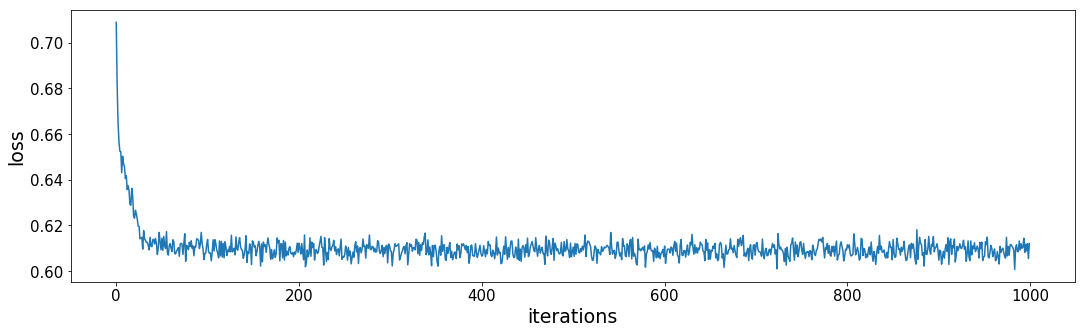

In [48]:
model = ClassificationMDN(n_input=1, n_hidden_units=10, n_hidden_layers=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
trainer = Trainer(model, optimizer, verbose=True, classification=True)

n_epochs = 10
n_minibatch = int(ntrain / 100)

# train with training data
loss_trace = trainer.train(sx_zt, m, n_epochs=n_epochs, n_minibatch=n_minibatch)
plt.plot(loss_trace)
plt.ylabel('loss')
plt.xlabel('iterations');

### Visualize the NN input output function

In [49]:
# normalize 
sx_vis, training_norm = normalize(thetas, training_norm)
# predict probs of entire range
probs_vis = model.predict(sx_vis.reshape((thetas.size, 1)))

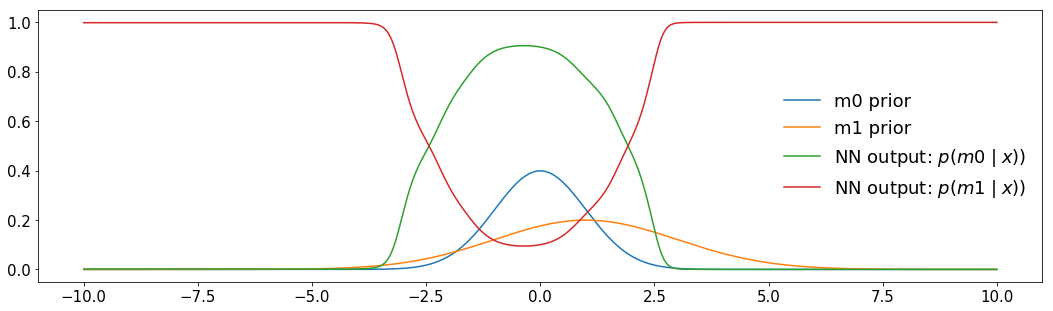

In [50]:
fig, ax = plt.subplots(figsize=(18, 5))
ax.plot(thetas, prior_m0.pdf(thetas), label='m0 prior')
ax.plot(thetas, prior_m1.pdf(thetas), label='m1 prior')
ax.plot(thetas, probs_vis[:, 0], label='NN output: $p(m0 \;|\; x))$')
ax.plot(thetas, probs_vis[:, 1], label='NN output: $p(m1 \;|\; x))$')
ax.legend();

## Approximate the exact posterior

In [51]:
def marginal_likelihood_integrant(mu, xo, model_std, prior_loc, prior_std): 
    return scipy.stats.norm.pdf(xo, loc=mu, scale=model_std) * scipy.stats.norm.pdf(mu, 
                                                                                loc=prior_loc, 
                                                                                scale=prior_std)

In [52]:
xos = np.linspace(-10, 10, 100)
marli0 = np.array([integrate.quad(marginal_likelihood_integrant, -10, 10, 
                                  args=(xo, m0.std, prior_m0.mean(), prior_m0.std())) for xo in xos])
marli1 = np.array([integrate.quad(marginal_likelihood_integrant, -10, 10, 
                                  args=(xo, m1.std, prior_m1.mean(), prior_m1.std())) for xo in xos])

In [53]:
p_m1_given_xo = marli1[:, 0] / (marli1[:, 0] + marli0[:, 0])

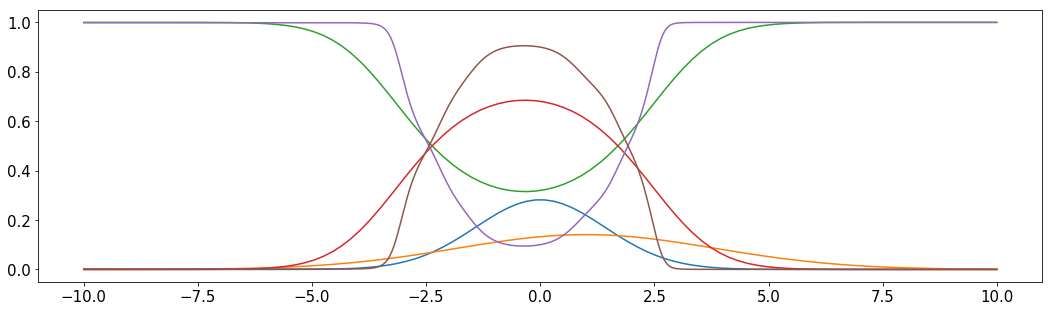

In [54]:
plt.plot(xos, marli0[:, 0])
plt.plot(xos, marli1[:, 0])
plt.plot(xos, p_m1_given_xo)
plt.plot(xos, 1 - p_m1_given_xo)
plt.plot(thetas, probs_vis[:, 1], label='NN output: $p(m1 \;|\; x))$')
plt.plot(thetas, probs_vis[:, 0], label='NN output: $p(m1 \;|\; x))$')
